In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading and Cleaning Data

In [209]:
df = pd.read_csv('recom.csv')

In [210]:
df.shape

(50000, 8)

In [211]:
df. head()

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey
0,0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,5002.0,1.0,5002.0
1,1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,35012.0,1.0,NaN
2,2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,5005.0,1.0,5005.0
3,3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,35078.5,1.0,NaN
4,4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,49291.5,5.0,NaN


In [212]:
# Dropping  Unnamed: 0  column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [213]:
# Check if not null ItemKey = Code_product
df[df['ItemKey'].notnull()].loc[df['ItemKey'] != df['Code_Product']]

,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey


* we can see from above cell that ItemKey =  Code_roduct, so we can drop ItemKey column as it has nulls.

In [214]:
df = df.drop('ItemKey', axis=1)

In [215]:
# Check for null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Main_ID         50000 non-null  object 
 1   Transaction_ID  50000 non-null  object 
 2   Date            50000 non-null  object 
 3   Price           50000 non-null  float64
 4   Code_Product    50000 non-null  float64
 5   Amount          50000 non-null  float64
dtypes: float64(3), object(3)
memory usage: 2.3+ MB


* Checking if we have the same product for each user in different Transactions to see if we need to aggregate Amount column.

In [216]:
df.shape[0] == df.groupby(['Main_ID', 'Code_Product']).size().shape[0]

False

* So, we do have the same product for each user in different Transactions, so we need to aggregate Amount column. This will also leave out colums we don't need.

In [219]:
df = df.groupby(['Main_ID', 'Code_Product']).agg({'Amount': 'sum', 'Price' : 'max'}).reset_index()

In [222]:
df.head()

,Main_ID,Code_Product,Amount,Price
0,00024de6,35097.0,2.0,6.0
1,00084856,49291.5,1.0,22.0
2,00084856,49292.0,1.0,24.0
3,0008e848,40002.0,1.0,13.0
4,00096930,49291.5,2.0,48.0


In [223]:
df.shape

(45901, 4)

* Now all data clean and we can start with recommendation system.

### Simple Product-Based Recommender
* Here we will use Correlation coeficient to find similar products.
1. Dropping unnecessary columns.
2. Creating rating for each product per user.
3. Creating correlation matrix for each product.
4. Creating a function to find similar products.

#### Creating rating for each product per user.

In [224]:
df.head()

,Main_ID,Code_Product,Amount,Price
0,00024de6,35097.0,2.0,6.0
1,00084856,49291.5,1.0,22.0
2,00084856,49292.0,1.0,24.0
3,0008e848,40002.0,1.0,13.0
4,00096930,49291.5,2.0,48.0


In [225]:
s = df['Amount'].unique()
s.sort()
print(s)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 28. 33. 41. 54.]


* We will use Amount column as rating for each product per user. And leave only Main_ID (user), Code_Product (product) and Amount (rating) columns.

In [227]:
df_simple_rec = df.drop(columns=['Price'])

In [228]:
df_simple_rec['Amount'] = df_simple_rec['Amount'].astype(int)

In [229]:
df_simple_rec.head()

,Main_ID,Code_Product,Amount
0,00024de6,35097.0,2
1,00084856,49291.5,1
2,00084856,49292.0,1
3,0008e848,40002.0,1
4,00096930,49291.5,2


In [68]:
# renaming columns
df_simple_rec.rename(columns={'Main_ID': 'user_id', 'Code_Product': 'item_id', 'Amount': 'rating'}, inplace=True)

#### Creating correlation matrix for each product.

In [72]:
df_CM_simple_rec = pd.pivot_table(df_simple_rec, index='user_id', columns='item_id', values='rating').corr()

* Now we can see what products are similar to each other and if user like product 5007.0, we can see what else we can reccomend to him - 5001.5, 5017.0,5001.0. If we set arbitrary treshhold to coefficient 0 (line where negative correlation begins)

In [90]:
single_prod_corr = df_CM_simple_rec[5007.0].sort_values(ascending=False)
single_prod_corr.loc[single_prod_corr.values > 0]

item_id
5001.5    1.000000
5007.0    1.000000
5017.0    1.000000
5001.0    0.174078
Name: 5007.0, dtype: float64

* Finding similar products to all users in our dataset.

In [159]:
rec_dict = {'user_id':[],
            'purchased_item_id':[],
            'reccomended_item':[],
            'correlations_coeff':[]}

for g in df_simple_rec.groupby('user_id'):
    for i in g[1]['item_id']:
        single_prod_corr = df_CM_simple_rec[i].sort_values(ascending=False)
        positive_single_prod_corr = single_prod_corr.loc[single_prod_corr.values > 0]

        for j in positive_single_prod_corr.index:
            rec_dict['user_id'].append(g[0])
            rec_dict['purchased_item_id'].append(i)
            rec_dict['reccomended_item'].append(j)
            rec_dict['correlations_coeff'].append(positive_single_prod_corr[j])


df_simpl_rec_final = pd.DataFrame(rec_dict)
df_simpl_rec_final['correlations_coeff'] = df_simpl_rec_final['correlations_coeff'].apply(lambda x: round(x, 2))
df_simpl_rec_final.index = pd.MultiIndex.from_arrays([df_simpl_rec_final['user_id'], 
                                                    df_simpl_rec_final['purchased_item_id'],
                                                    df_simpl_rec_final['reccomended_item']])
df_simpl_rec_final.drop(columns=['user_id','purchased_item_id','reccomended_item'], inplace=True)

* Now we have a data frame with all users, purchsed item and items to reccomend to them. Let's see top 10 items for user '00084856' and his purchased item '49291.5'. 

In [167]:
df_simpl_rec_final.loc[('00084856','49291.5')].head(10)

,correlations_coeff
reccomended_item,
49291.5,1.00
35006.5,1.00
45013.5,1.00
35071.5,1.00
15022.5,1.00
40003.0,0.94
40075.0,0.87
5005.0,0.83
10031.0,0.76


* In above solution I have not taken into account anything but how many times product was bought by users. So, similatiry of products were only based on how many times they were bought by users. But we can improve our solution by taking into account price of products. So, if user bought 1 product 5007.0 for 1000, and 2 products 5001.5 for 2000, we can see that user prefers products with higher price range. So, we can use price of product as a weight for rating.

#### Product-Based Recommender with Price as a Weight

In [230]:
df.head(2)

,Main_ID,Code_Product,Amount,Price
0,00024de6,35097.0,2.0,6.0
1,00084856,49291.5,1.0,22.0


* Let's see how we will bin our price column to use it as a weight for rating.

In [232]:
df_simple_rep_w_price = df.copy(deep=True)
df_simple_rep_w_price['Price'].describe()

count    45901.000000
mean        62.541350
std         67.698052
min          0.500000
25%         25.000000
50%         45.500000
75%         83.000000
max       2525.500000
Name: Price, dtype: float64

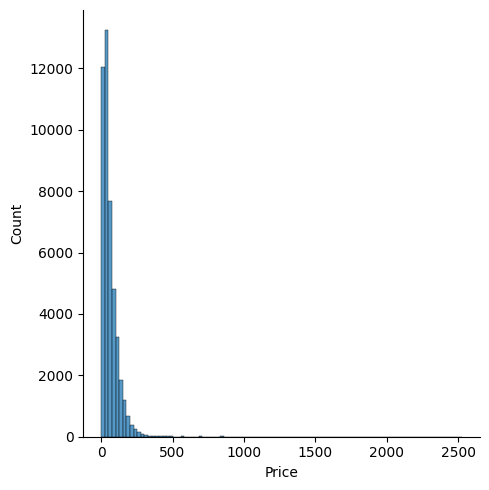

In [233]:
# plot Price distribution
sns.displot(df_simple_rep_w_price['Price'], bins=100)

In [234]:
# create Price bins as columns with 1 if item is in bin and 0 if not
df_simple_rep_w_price['Price_bin_0-25'] = df_simple_rep_w_price['Price'].apply(lambda x: 1 if x < 25 else 0)
df_simple_rep_w_price['Price_bin_25-50'] = df_simple_rep_w_price['Price'].apply(lambda x: 1 if x >= 25 and x < 50 else 0)
df_simple_rep_w_price['Price_bin_50-80'] = df_simple_rep_w_price['Price'].apply(lambda x: 1 if x >= 50 and x < 80 else 0)
df_simple_rep_w_price['Price_bin_80-max'] = df_simple_rep_w_price['Price'].apply(lambda x: 1 if x >= 80 else 0)

In [235]:
df_simple_rep_w_price = df_simple_rep_w_price.drop('Price', axis=1)

In [236]:
df_simple_rep_w_price['Amount'] = df_simple_rep_w_price['Amount'].astype(int)
df_simple_rep_w_price.head(2)

,Main_ID,Code_Product,Amount,Price_bin_0-25,Price_bin_25-50,Price_bin_50-80,Price_bin_80-max
0,00024de6,35097.0,2,1,0,0,0
1,00084856,49291.5,1,1,0,0,0


In [237]:
df_simple_rep_w_price.rename(columns={'Main_ID': 'user_id', 'Code_Product': 'item_id', 'Amount': 'rating'}, inplace=True)
df_simple_rep_w_price.head(2)

,user_id,item_id,rating,Price_bin_0-25,Price_bin_25-50,Price_bin_50-80,Price_bin_80-max
0,00024de6,35097.0,2,1,0,0,0
1,00084856,49291.5,1,1,0,0,0


In [238]:
df_simple_rep_w_price.shape

(45901, 7)